<a href="https://colab.research.google.com/github/BenWilop/WSG_games/blob/main/playground_WSG_games.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import getpass
import dotenv
import wandb
import os
dotenv.load_dotenv(os.path.join('/homes/55/bwilop/wsg/private/', 'vscode-ssh.env'))
api_key = os.getenv('WANDB_API_KEY')
wandb.login(key=api_key)

data_folder = '/homes/55/bwilop/wsg/data/'
experiment_folder = '/homes/55/bwilop/wsg/experiments/'

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /homes/55/bwilop/.netrc
wandb: Currently logged in as: benwilop (benwilop-rwth-aachen-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [2]:
%load_ext autoreload
%autoreload 2
import torch as t
import torch.nn as nn
from torch.nn.functional import cross_entropy, softmax
from torch import Tensor
from jaxtyping import Float
from tqdm import tqdm
from transformer_lens import HookedTransformerConfig, HookedTransformer
import json
from typing import Callable, Any
import einops
import time
import uuid
import glob
from copy import deepcopy
import matplotlib.pyplot as plt
from datetime import datetime
import torch.nn as nn

from wsg_games.tictactoe.evals import *
from wsg_games.tictactoe.data import *
from wsg_games.tictactoe.game import *

from wsg_games.tictactoe.analysis.analyse_data import *
from wsg_games.tictactoe.analysis.visualize_game import *

from wsg_games.tictactoe.train.create_models import *
from wsg_games.tictactoe.train.save_load_models import *
from wsg_games.tictactoe.train.train import *
from wsg_games.tictactoe.train.finetune import *
from wsg_games.tictactoe.train.pretrain import *

device = t.device("cuda" if t.cuda.is_available() else "cpu")
print(device)

cuda


# Data

In [3]:
# tictactoe_data = cache_tictactoe_data(data_folder + 'tictactoe_data.pkl')
tictactoe_data = cache_tictactoe_data_random(data_folder + 'tictactoe_data_random_STRONG_RULE_REVERSE_RULE.pkl')
# tictactoe_data = cache_tictactoe_data_random(data_folder + 'tictactoe_data_random_STRONG_RULE_NO_DIAGONAL.pkl')
print_data_statistics(tictactoe_data)

Shape Data:    torch.Size([200000, 10])
Shape Random:  torch.Size([200000, 10, 10])
Shape Weak:    torch.Size([200000, 10, 10])
Shape Strong:  torch.Size([200000, 10, 10])
--------------------------------------------------------
Evals Random:  {'weak_accuracy': 0.6971979737281799, 'strong_accuracy': 0.6485714912414551, 'illegal_move_chance': 0.0}
Evals Weak:    {'weak_accuracy': 1.0, 'strong_accuracy': 0.5115560293197632, 'illegal_move_chance': 0.0}
Evals Strong:  {'weak_accuracy': 0.5757150053977966, 'strong_accuracy': 1.0, 'illegal_move_chance': 0.0}
--------------------------------------------------------
Entropy Random:  0.8480209708213806
Entropy Weak:    0.3486904203891754
Entropy Strong:  0.4996753931045532
--------------------------------------------------------


In [4]:
# tictactoe_train_data, weak_finetune_data, tictactoe_val_data, tictactoe_test_data = train_test_split_tictactoe(tictactoe_data, 0.5, 0.25, 0.05, 0.20, device, 1234)
tictactoe_train_data, tictactoe_weak_finetune_data, tictactoe_val_data, tictactoe_test_data = train_test_split_tictactoe_first_two_moves_no_overlap(tictactoe_data, 42, 15, 5, 10, device, 1234)

print("Shape Train: ", tictactoe_train_data.games_data.shape)
print("Shape Weak Finetune: ", tictactoe_weak_finetune_data.games_data.shape)
print("Shape Validation: ", tictactoe_val_data.games_data.shape)
print("Shape Test:  ", tictactoe_test_data.games_data.shape)

Shape Train:  torch.Size([116742, 10])
Shape Weak Finetune:  torch.Size([41581, 10])
Shape Validation:  torch.Size([13938, 10])
Shape Test:   torch.Size([27739, 10])


In [5]:
leakage_pct = calculate_leakage_percentage(tictactoe_train_data, tictactoe_test_data)
print(f"Leakage Percentage: {leakage_pct:.2f}%")

Leakage Percentage: 0.00%


In [6]:
# plot_train_test_prefix_histograms(tictactoe_train_data, tictactoe_test_data)

In [7]:
import torch.nn.functional as F

def sample_hard_labels_from_soft(soft_labels: t.Tensor, num_samples) -> t.Tensor:
    n_games, game_length, n_tokens = soft_labels.shape
    soft_labels_flat = soft_labels.view(-1, n_tokens)
    sampled_indices = t.multinomial(soft_labels_flat, num_samples=num_samples, replacement=True)

    one_hot_samples = F.one_hot(sampled_indices, num_classes=n_tokens).float()
    one_hot_samples = one_hot_samples.view(n_games, game_length, num_samples, n_tokens)
    one_hot_samples = one_hot_samples.permute(0, 2, 1, 3)
    new_hard_labels = one_hot_samples.reshape(n_games * num_samples, game_length, n_tokens)
    return new_hard_labels

def create_hard_label_tictactoe_data(data: TicTacToeData, num_samples, random_seed: int = 4567) -> TicTacToeData:
    """
    Samples for weak and strong goal one fixed trajectory.
    The random samples stay the same to make it easier to check for illegal moves.
    """
    t.manual_seed(random_seed)
    new_games_data = data.games_data.repeat_interleave(num_samples, dim=0)
    new_weak_goals_labels  = sample_hard_labels_from_soft(data.weak_goals_labels, num_samples=num_samples)
    new_strong_goals_labels = sample_hard_labels_from_soft(data.strong_goals_labels, num_samples=num_samples)
    return TicTacToeData(
        games_data=new_games_data,
        random_move_labels=data.random_move_labels,
        weak_goals_labels=new_weak_goals_labels,
        strong_goals_labels=new_strong_goals_labels
    )

tictactoe_train_data = create_hard_label_tictactoe_data(tictactoe_train_data, num_samples=1)
tictactoe_weak_finetune_data = create_hard_label_tictactoe_data(tictactoe_weak_finetune_data, num_samples=1)
tictactoe_val_data = create_hard_label_tictactoe_data(tictactoe_val_data, num_samples=1)

In [8]:
print("Shape Train: ", tictactoe_train_data.games_data.shape)
tictactoe_train_data.weak_goals_labels[0][:3]

Shape Train:  torch.Size([116742, 10])


tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]], device='cuda:0')

In [9]:
print("Shape Weak Finetune: ", tictactoe_weak_finetune_data.games_data.shape)
tictactoe_weak_finetune_data.weak_goals_labels[0][:3]

Shape Weak Finetune:  torch.Size([41581, 10])


tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]], device='cuda:0')

In [10]:
print("Shape Val: ", tictactoe_val_data.games_data.shape)
tictactoe_val_data.weak_goals_labels[0][:3]

Shape Val:  torch.Size([13938, 10])


tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]], device='cuda:0')

In [11]:
print("Shape Test:  ", tictactoe_test_data.games_data.shape)
tictactoe_test_data.weak_goals_labels[0][:3]

Shape Test:   torch.Size([27739, 10])


tensor([[0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.3333, 0.0000, 0.3333,
         0.0000]], device='cuda:0')

# Train model

In [12]:
# raise Exception()

### Parameters

In [13]:
training_cfg = {
    "learning_rate": 1e-3, # 1e-4,
    "weight_decay": 1e-4,  # 1e-5,
    "max_epochs": 1000,
    "early_stopping_patience": 3,
    "batch_size": 64,
}

model_sizes = {}
model_sizes["nano"]   = {"n_layers": 1, "n_heads": 1, "d_model": 1, "d_head": 1, "d_mlp": 4}
model_sizes["micro"]   = {"n_layers": 1, "n_heads": 2, "d_model": 4, "d_head": 2, "d_mlp": 16}
model_sizes["mini"]   = {"n_layers": 2, "n_heads": 4, "d_model": 8, "d_head": 2, "d_mlp": 32}

model_sizes["small"] = {"n_layers": 3, "n_heads": 4, "d_model": 16, "d_head": 4, "d_mlp": 64}
model_sizes["medium"] = {"n_layers": 4, "n_heads": 8, "d_model": 32, "d_head": 4, "d_mlp": 128}
model_sizes["large"] = {"n_layers": 5, "n_heads": 8, "d_model": 64, "d_head": 8, "d_mlp": 256}

model_sizes["huge"]   = {"n_layers": 6, "n_heads": 16, "d_model": 128, "d_head": 8,  "d_mlp": 512}
# model_sizes["gigantic"] = {"n_layers": 7, "n_heads": 16, "d_model": 256, "d_head": 16, "d_mlp": 1024}

# model_size_to_epochs = {
#                 # roughly converged after
#     "nano": 3,  # 1
#     "micro": 20,  # 10
#     "mini": 40,  # 20
#     "small": 50,  # 35
#     "medium": 4,  # 2
#     "large": 2,  # 1
#     # "huge": 1,
#     # "gigantic": 1
# }


def get_model_config(size: str):
    common_params = {
        "act_fn": "relu",
        "normalization_type": "LN",
        "d_vocab": 11,
        "d_vocab_out": 10,
        "n_ctx": 10,
        "init_weights": True,
        "device": "cuda",
        "seed": 1337,
    }
    specific = model_sizes[size]
    return HookedTransformerConfig(**specific, **common_params)

print_model_ratios(model_sizes, get_model_config)

Moving model to device:  cuda
nano 6.8 * 10^01


Moving model to device:  cuda
micro 3.9 * 10^02
Moving model to device:  cuda
mini 2.0 * 10^03
Moving model to device:  cuda
small 1.0 * 10^04
Moving model to device:  cuda
medium 5.2 * 10^04
Moving model to device:  cuda
large 2.5 * 10^05
Moving model to device:  cuda
huge 1.2 * 10^06
Ratio of consecutive model-sizes:  [5.676470588235294, 5.227979274611399, 5.142715559960357, 4.9992291385623435, 4.857985428472302, 4.736774029725204]


### wandb

### Train loop

In [14]:
from wsg_games.tictactoe.evals import *
from wsg_games.tictactoe.data import *
from wsg_games.tictactoe.game import *

from wsg_games.tictactoe.analysis.analyse_data import *
from wsg_games.tictactoe.analysis.visualize_game import *

from wsg_games.tictactoe.train.create_models import *
from wsg_games.tictactoe.train.save_load_models import *
from wsg_games.tictactoe.train.train import *
from wsg_games.tictactoe.train.finetune import *
from wsg_games.tictactoe.train.pretrain import *

In [15]:
# project_name = "tictactoe_playground"
# model_size = "large"
# model_cfg = get_model_config(model_size)
# wandb.finish()
# model, _, _ = run_full_training(project_name, model_size, Goal.STRONG_GOAL, tictactoe_train_data, tictactoe_val_data, tictactoe_test_data, training_cfg, model_cfg)

### Experiments

In [16]:
project_name = "tictactoe_pretrained_reverse_rule_no_overlap_split_start_third_200k"
# project_name = "tictactoe_pretrained_forbidden_diagonals_no_overlap_split_start_third_200k"
# pretrain_models(experiment_folder, project_name, tictactoe_train_data, tictactoe_val_data, tictactoe_test_data, training_cfg, get_model_config)

Loading model from /homes/55/bwilop/wsg/experiments//tictactoe_pretrained_reverse_rule_no_overlap_split_start_third_200k/experiment_nano_weak_2025-03-17-11-01_l0yq7mf2.pkl
Moving model to device:  cpu
Loading model from /homes/55/bwilop/wsg/experiments//tictactoe_pretrained_reverse_rule_no_overlap_split_start_third_200k/experiment_nano_strong_2025-03-17-11-03_qsmciq80.pkl
Moving model to device:  cpu
Loading model from /homes/55/bwilop/wsg/experiments//tictactoe_pretrained_reverse_rule_no_overlap_split_start_third_200k/experiment_micro_weak_2025-03-17-11-05_c0ud9wk2.pkl
Moving model to device:  cpu
Loading model from /homes/55/bwilop/wsg/experiments//tictactoe_pretrained_reverse_rule_no_overlap_split_start_third_200k/experiment_micro_strong_2025-03-17-11-10_lcifn598.pkl
Moving model to device:  cpu
Loading model from /homes/55/bwilop/wsg/experiments//tictactoe_pretrained_reverse_rule_no_overlap_split_start_third_200k/experiment_mini_weak_2025-03-17-11-15_gp6nbh3i.pkl
Moving model to de

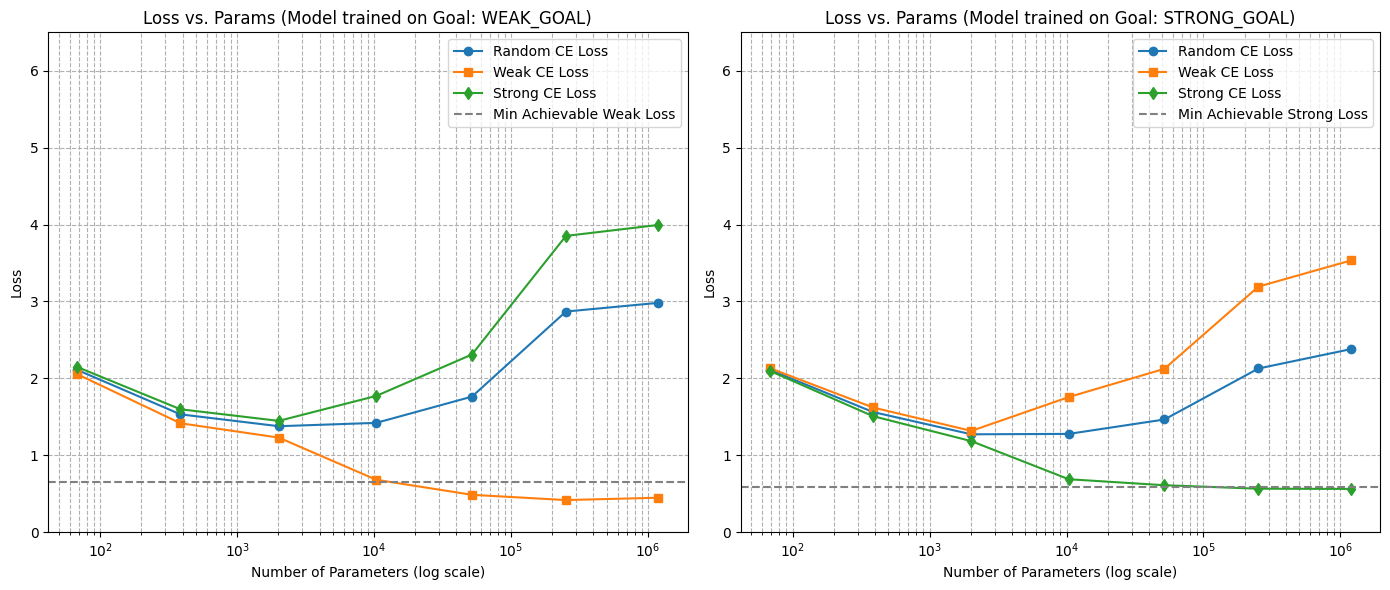

In [17]:
plot_loss_pretrain_models(experiment_folder, project_name, tictactoe_test_data)

In [18]:
# project_name = "tictactoe_pretrained_reverse_rule_no_overlap_split_start_third_200k"
# weak_model_weak_goals = load_model(project_name, "mini", Goal.WEAK_GOAL, experiment_folder)
# strong_model_weak_goals = load_model(project_name, "medium", Goal.WEAK_GOAL, experiment_folder)
# strong_model_strong_goals = load_model(project_name, "medium", Goal.STRONG_GOAL, experiment_folder)
# quick_evaluation("Weak model weak goal", weak_model_weak_goals, tictactoe_test_data)
# quick_evaluation("Strong model weak goal", strong_model_weak_goals, tictactoe_test_data)
# quick_evaluation("Strong model strong goal", strong_model_strong_goals, tictactoe_test_data)
# strong_model_finetuned = deepcopy(strong_model_strong_goals)

# project_name = "tictactoe_playground"
# timestamp = datetime.now().strftime("%Y-%m-%d-%H-%M")
# experiment_name = f"experiment_finetuning_{timestamp}"
# # Use validation data as weak_train_data
# finetune_strong_with_weak(project_name, experiment_name, weak_model_weak_goals, strong_model_finetuned, tictactoe_weak_finetune_data, tictactoe_test_data, adapted_training_cfg)

In [19]:
pretrained_project_name = "tictactoe_pretrained_reverse_rule_no_overlap_split_start_third_200k" 
finetuned_project_name = "finetune_sweep_test"
# finetune_sweep(pretrained_project_name, finetuned_project_name, experiment_folder, tictactoe_weak_finetune_data, tictactoe_val_data, tictactoe_test_data, training_cfg)

In [20]:
load_finetuned_model_get_matching_files(finetuned_project_name, "micro", "medium", experiment_folder)

['/homes/55/bwilop/wsg/experiments/finetune_sweep_test/experiment_micro_medium_2025-03-17-16-32_r08c4g5r.pkl']

In [21]:
raise Exception()

Exception: 

Loading model from /homes/55/bwilop/wsg/experiments//tictactoe_pretrained_reverse_rule_no_overlap_split_start_third_200k/experiment_nano_weak_2025-03-17-11-01_l0yq7mf2.pkl
Loading model from /homes/55/bwilop/wsg/experiments//tictactoe_pretrained_reverse_rule_no_overlap_split_start_third_200k/experiment_micro_weak_2025-03-17-11-05_c0ud9wk2.pkl
Loading model from /homes/55/bwilop/wsg/experiments//tictactoe_pretrained_reverse_rule_no_overlap_split_start_third_200k/experiment_micro_strong_2025-03-17-11-10_lcifn598.pkl
Loading model from /homes/55/bwilop/wsg/experiments//tictactoe_pretrained_reverse_rule_no_overlap_split_start_third_200k/experiment_mini_weak_2025-03-17-11-15_gp6nbh3i.pkl
Loading model from /homes/55/bwilop/wsg/experiments//tictactoe_pretrained_reverse_rule_no_overlap_split_start_third_200k/experiment_mini_strong_2025-03-17-11-20_yw4m6hui.pkl
Loading model from /homes/55/bwilop/wsg/experiments//tictactoe_pretrained_reverse_rule_no_overlap_split_start_third_200k/experiment_sm

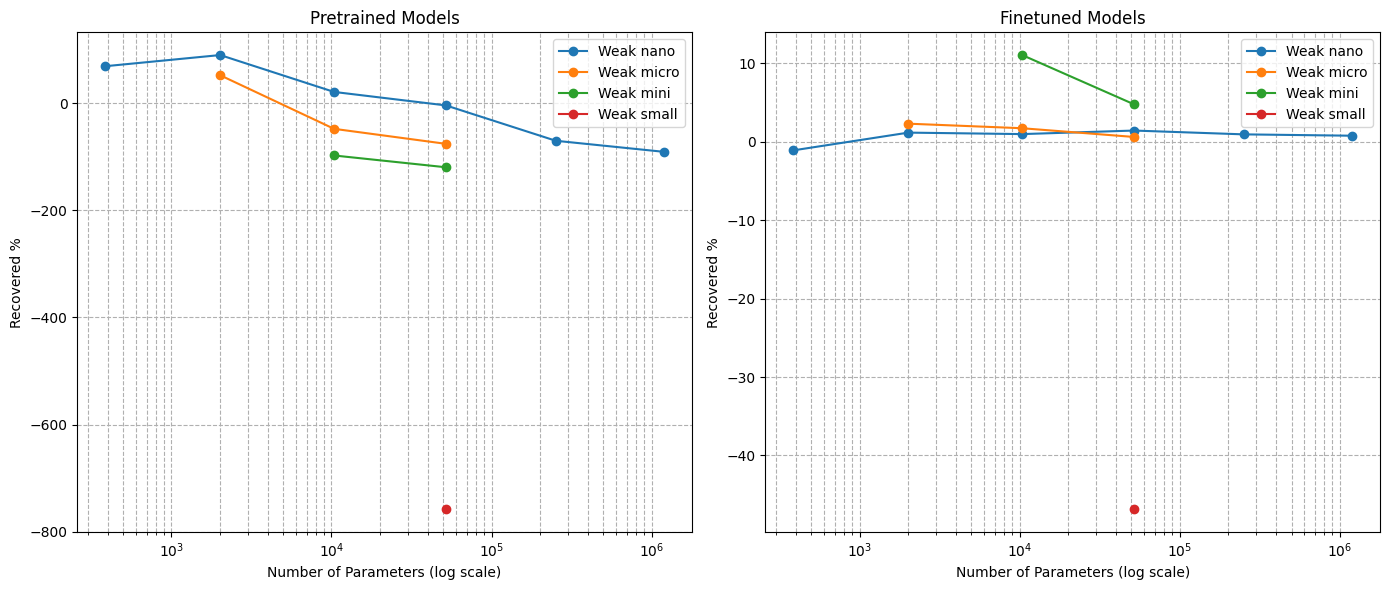

In [23]:
import os
import glob
import torch as t

# Helper: compute loss on test data
def get_weak_loss(model, test_data: TicTacToeData, n_samples: int = 20000) -> float:
    model.eval()
    with t.no_grad():
        sample = random_sample_tictactoe_data(test_data, n_samples)
        logits = model(sample.games_data)
        loss = cross_entropy(rearrange(logits), rearrange(sample.weak_goals_labels)).item()
    return loss


def visualize_finetuning_results(pretrained_project_name: str, finetuned_project_name: str, 
                                 experiment_folder: str, test_data: TicTacToeData, 
                                 model_sizes: list):
    """
    For each weak_size and for every strong_size larger than weak_size,
    compute the recovered percentage:
    
        recovered % = (L_weak - L_model) / (L_weak - L_strong_baseline) * 100
    
    where:
      - L_weak: loss of the weak model (evaluated on weak_goals)
      - L_strong_baseline: loss of the pretrained strong model on the weak goal
      - L_model: loss of either the pretrained strong model (for the left plot) or the finetuned model (for the right plot)
      
    The x-axis is the number of parameters in the strong model (log-scaled).
    One line is drawn per weak model size, connecting datapoints for each strong size.
    Two subplots are created: left for pretrained models and right for finetuned models.
    """
    data_pretrained = {}  # { weak_size: list of (num_params, recovered %) }
    data_finetuned = {}
    
    for weak_size in model_sizes:
        weak_model = load_model(pretrained_project_name, weak_size, 
                                Goal.WEAK_GOAL, experiment_folder)
        if not weak_model:
            print(f"Weak model of size {weak_size} not found, skipping.")
            continue
        
        # Get loss of weak model (using weak labels)
        L_weak = get_weak_loss(weak_model, test_data)
        data_pretrained[weak_size] = []
        data_finetuned[weak_size] = []
        
        for strong_size in model_sizes:
            if model_sizes.index(strong_size) <= model_sizes.index(weak_size):
                continue
            
            strong_model_weak_goal = load_model(pretrained_project_name, strong_size, 
                                                 Goal.WEAK_GOAL, experiment_folder)
            strong_model_strong_goal = load_model(pretrained_project_name, strong_size, 
                                                 Goal.STRONG_GOAL, experiment_folder)
            if not strong_model_weak_goal or not strong_model_strong_goal:
                print(f"Strong models of size {strong_size} not found, skipping.")
                continue
            
            num_params = count_parameters(strong_model_weak_goal)
            L_strong_baseline = get_weak_loss(strong_model_weak_goal, test_data)
            L_strong_pretrained_on_weak_goal = get_weak_loss(strong_model_strong_goal, test_data)
            
            # Left plot
            recovered_pretrained = (L_weak - L_strong_pretrained_on_weak_goal) / (L_weak - L_strong_baseline) * 100 

            # Right plot
            finetuned_model = load_finetuned_model(finetuned_project_name, weak_size, strong_size, experiment_folder)
            if not finetuned_model:
                print(f"Finetuned model of size {strong_size} not found, skipping.")
                continue

            L_finetuned = get_weak_loss(finetuned_model, test_data)
            recovered_finetuned = (L_weak - L_finetuned) / (L_weak - L_strong_baseline) * 100
            
            data_pretrained[weak_size].append((num_params, recovered_pretrained))
            data_finetuned[weak_size].append((num_params, recovered_finetuned))
    
    # Create two subplots: left for pretrained, right for finetuned.
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot pretrained data.
    for weak_size, points in data_pretrained.items():
        if points:
            points.sort(key=lambda x: x[0])
            x_vals = [p[0] for p in points]
            y_vals = [p[1] for p in points]
            axes[0].plot(x_vals, y_vals, marker='o', label=f"Weak {weak_size}")
    axes[0].set_xscale('log')
    axes[0].set_xlabel("Number of Parameters (log scale)")
    axes[0].set_ylabel("Recovered %")
    axes[0].set_title("Pretrained Models")
    axes[0].legend()
    axes[0].grid(True, which="both", ls="--")
    
    # Plot finetuned data.
    for weak_size, points in data_finetuned.items():
        if points:
            points.sort(key=lambda x: x[0])
            x_vals = [p[0] for p in points]
            y_vals = [p[1] for p in points]
            axes[1].plot(x_vals, y_vals, marker='o', label=f"Weak {weak_size}")
    axes[1].set_xscale('log')
    axes[1].set_xlabel("Number of Parameters (log scale)")
    axes[1].set_ylabel("Recovered %")
    axes[1].set_title("Finetuned Models")
    axes[1].legend()
    axes[1].grid(True, which="both", ls="--")
    
    plt.tight_layout()
    plt.show()

visualize_finetuning_results(pretrained_project_name, finetuned_project_name, 
                                 experiment_folder, tictactoe_test_data, 
                                 ["nano", "micro", "mini", "small", "medium", "large", "huge"])

In [ ]:
raise Exception()

# Inspect model

In [ ]:
project_name = "tictactoe_pretrained_reverse_rule_no_overlap_split_start_third_200k"
model = load_model(project_name, "large", Goal.STRONG_GOAL, experiment_folder)
quick_evaluation("model weak goal", model, tictactoe_test_data)

Loading model from /homes/55/bwilop/wsg/experiments//tictactoe_pretrained_reverse_rule_no_overlap_split_start_third_200k/experiment_large_strong_2025-03-17-12-30_3z524rtf.pkl
model weak goal
weak_loss:  3.205887794494629
strong_loss:  0.5628676414489746


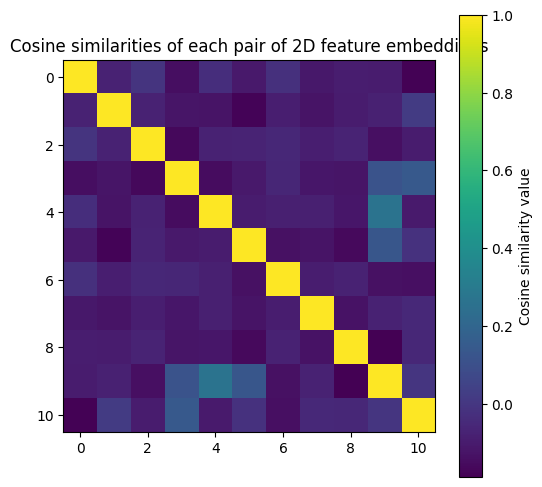

In [ ]:
W = model.embed.W_E
W_normed = W / W.norm(dim=1, keepdim=True)

# Compute cosine similarity matrix and move to CPU as a NumPy array
cosine_sim = (W_normed @ W_normed.T).detach().cpu().numpy()

im = plt.imshow(cosine_sim)
plt.title("Cosine similarities of each pair of 2D feature embeddings")
plt.gcf().set_size_inches(6, 6)

# Add a colorbar with a label
cbar = plt.colorbar(im)
cbar.set_label("Cosine similarity value")

plt.show()

In [ ]:
W.shape

torch.Size([11, 64])

In [ ]:
train_sample = random_sample_tictactoe_data(tictactoe_train_data, 1)
train_logits = model(train_sample.games_data)
soft_labels = softmax(train_logits, dim=-1)
hard_labels = F.one_hot(train_sample.weak_goals_labels.argmax(dim=-1), num_classes=train_logits.shape[-1]).float()

print(train_sample.weak_goals_labels.shape)
print(train_logits.shape)
print(soft_labels.shape)
print(hard_labels.shape)

torch.Size([1, 10, 10])
torch.Size([1, 10, 10])
torch.Size([1, 10, 10])
torch.Size([1, 10, 10])


In [ ]:
train_sample.weak_goals_labels

tensor([[[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]], device='cuda:0')

In [ ]:
soft_labels.clip(0.01)

tensor([[[0.0600, 0.2873, 0.0108, 0.0100, 0.0100, 0.0776, 0.0315, 0.3437,
          0.1858, 0.0100],
         [0.1310, 0.2038, 0.0711, 0.1421, 0.0100, 0.1694, 0.1454, 0.0100,
          0.1278, 0.0100],
         [0.1651, 0.2080, 0.1531, 0.1961, 0.0220, 0.0100, 0.0659, 0.0100,
          0.1895, 0.0100],
         [0.2162, 0.2948, 0.2821, 0.2031, 0.0100, 0.0100, 0.0100, 0.0100,
          0.0100, 0.0100],
         [0.0100, 0.0100, 0.9990, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
          0.0100, 0.0100],
         [0.3378, 0.3487, 0.0100, 0.0100, 0.3094, 0.0100, 0.0100, 0.0100,
          0.0100, 0.0100],
         [0.0100, 0.0100, 0.0100, 0.9999, 0.0100, 0.0100, 0.0100, 0.0100,
          0.0100, 0.0100],
         [0.0100, 0.0100, 0.0100, 0.9998, 0.0100, 0.0100, 0.0100, 0.0100,
          0.0100, 0.0100],
         [0.0100, 0.0100, 0.0100, 1.0000, 0.0100, 0.0100, 0.0100, 0.0100,
          0.0100, 0.0100],
         [0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
          0.0100,

In [ ]:
hard_labels

tensor([[[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]], device='cuda:0')

In [ ]:
board = Board()
print(get_best_moves(board, Goal.WEAK_GOAL))
board.make_move(1)
print(get_best_moves(board, Goal.WEAK_GOAL))

[0, 1, 2, 3, 4, 5, 6, 7, 8]
[0, 2, 4, 7]


In [ ]:
tictactoe_test_data.games_data[600]

tensor([10,  4,  1,  8,  7,  2,  3,  0,  9,  9], device='cuda:0')

In [ ]:
tictactoe_test_data.weak_goals_labels[2]

tensor([[0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.3333, 0.0000, 0.3333,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.5000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.2500, 0.2500, 0.0000, 0.2500, 0.2500,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.2500, 0.0000, 0.2500, 0.2500, 0.2500,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.5000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         1.0000]], device='c

In [ ]:
tictactoe_test_data.games_data[25][:]

tensor([10,  4,  1,  0,  2,  6,  8,  7,  5,  9], device='cuda:0')

In [ ]:
softmax(model(tictactoe_test_data.games_data[25][:]), dim=-1).clip(0.01)

tensor([[[0.0600, 0.2873, 0.0108, 0.0100, 0.0100, 0.0776, 0.0315, 0.3437,
          0.1858, 0.0100],
         [0.1852, 0.1709, 0.0903, 0.0266, 0.0100, 0.0236, 0.1183, 0.1861,
          0.1989, 0.0100],
         [0.1824, 0.0100, 0.1345, 0.1324, 0.0100, 0.1236, 0.1418, 0.1531,
          0.1321, 0.0100],
         [0.0100, 0.0100, 0.1839, 0.1831, 0.0100, 0.1944, 0.2090, 0.2265,
          0.0100, 0.0100],
         [0.0100, 0.0100, 0.0100, 0.1705, 0.0100, 0.2039, 0.1645, 0.2310,
          0.2295, 0.0100],
         [0.0100, 0.0100, 0.0100, 0.3213, 0.0100, 0.3418, 0.0100, 0.3337,
          0.0100, 0.0100],
         [0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.9987,
          0.0100, 0.0100],
         [0.0100, 0.0100, 0.0100, 1.0000, 0.0100, 0.0100, 0.0100, 0.0100,
          0.0100, 0.0100],
         [0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
          0.0100, 1.0000],
         [0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
          0.0100,

In [ ]:
skip_to = 0
train_dataset = TensorDataset(
    tictactoe_train_data.games_data,
    tictactoe_train_data.random_move_labels,
    tictactoe_train_data.weak_goals_labels,
    tictactoe_train_data.strong_goals_labels,
)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
i = 0
for games, random_labels, weak_labels, strong_labels in train_loader:
    logits = model(games)
    probs = torch.softmax(logits, dim=-1)
    illegal_mask = (random_labels == 0).float()
    illegal_move_probs = (probs * illegal_mask).sum(dim=-1)
    avg_illegal = illegal_move_probs.mean().item()

    print(i, avg_illegal)

    i += 1
    if i > 100:
        break

0 0.01444177981466055
1 9.626190148992464e-05
2 0.0019580775406211615
3 0.00023599671840202063
4 0.0012325937859714031
5 6.710421439493075e-05
6 0.00028516899328678846
7 0.0006855648243799806
8 8.140345744322985e-05
9 0.00040492392145097256
10 0.00020433297322597355
11 0.0004424826183822006
12 0.00024070616927929223
13 9.353259520139545e-05
14 0.0034466739743947983
15 8.843032264849171e-05
16 0.00014082540292292833
17 0.0008493984933011234
18 0.00025496407761238515
19 0.000556216633412987
20 0.000373202288756147
21 0.00027639808831736445
22 0.00013532630691770464
23 0.001433534431271255
24 0.0018543507903814316
25 0.00017146773461718112
26 0.0007765197078697383
27 0.00031186561682261527
28 0.00015924281615298241
29 0.0004710099601652473
30 0.00036829523742198944
31 0.003419936401769519
32 8.966345922090113e-05
33 0.0002275978185934946
34 0.0014956268714740872
35 0.0022335138637572527
36 7.978682697284967e-05
37 0.00046473517431877553
38 0.0006715224008075893
39 0.00011476311192382127
4

tensor([10,  2,  0,  4,  8,  5,  7,  3,  9,  9], device='cuda:0')


/homes/55/bwilop/wsg/WSG_games/wsg_games/tictactoe/analysis/visualize_game.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.93, 1])


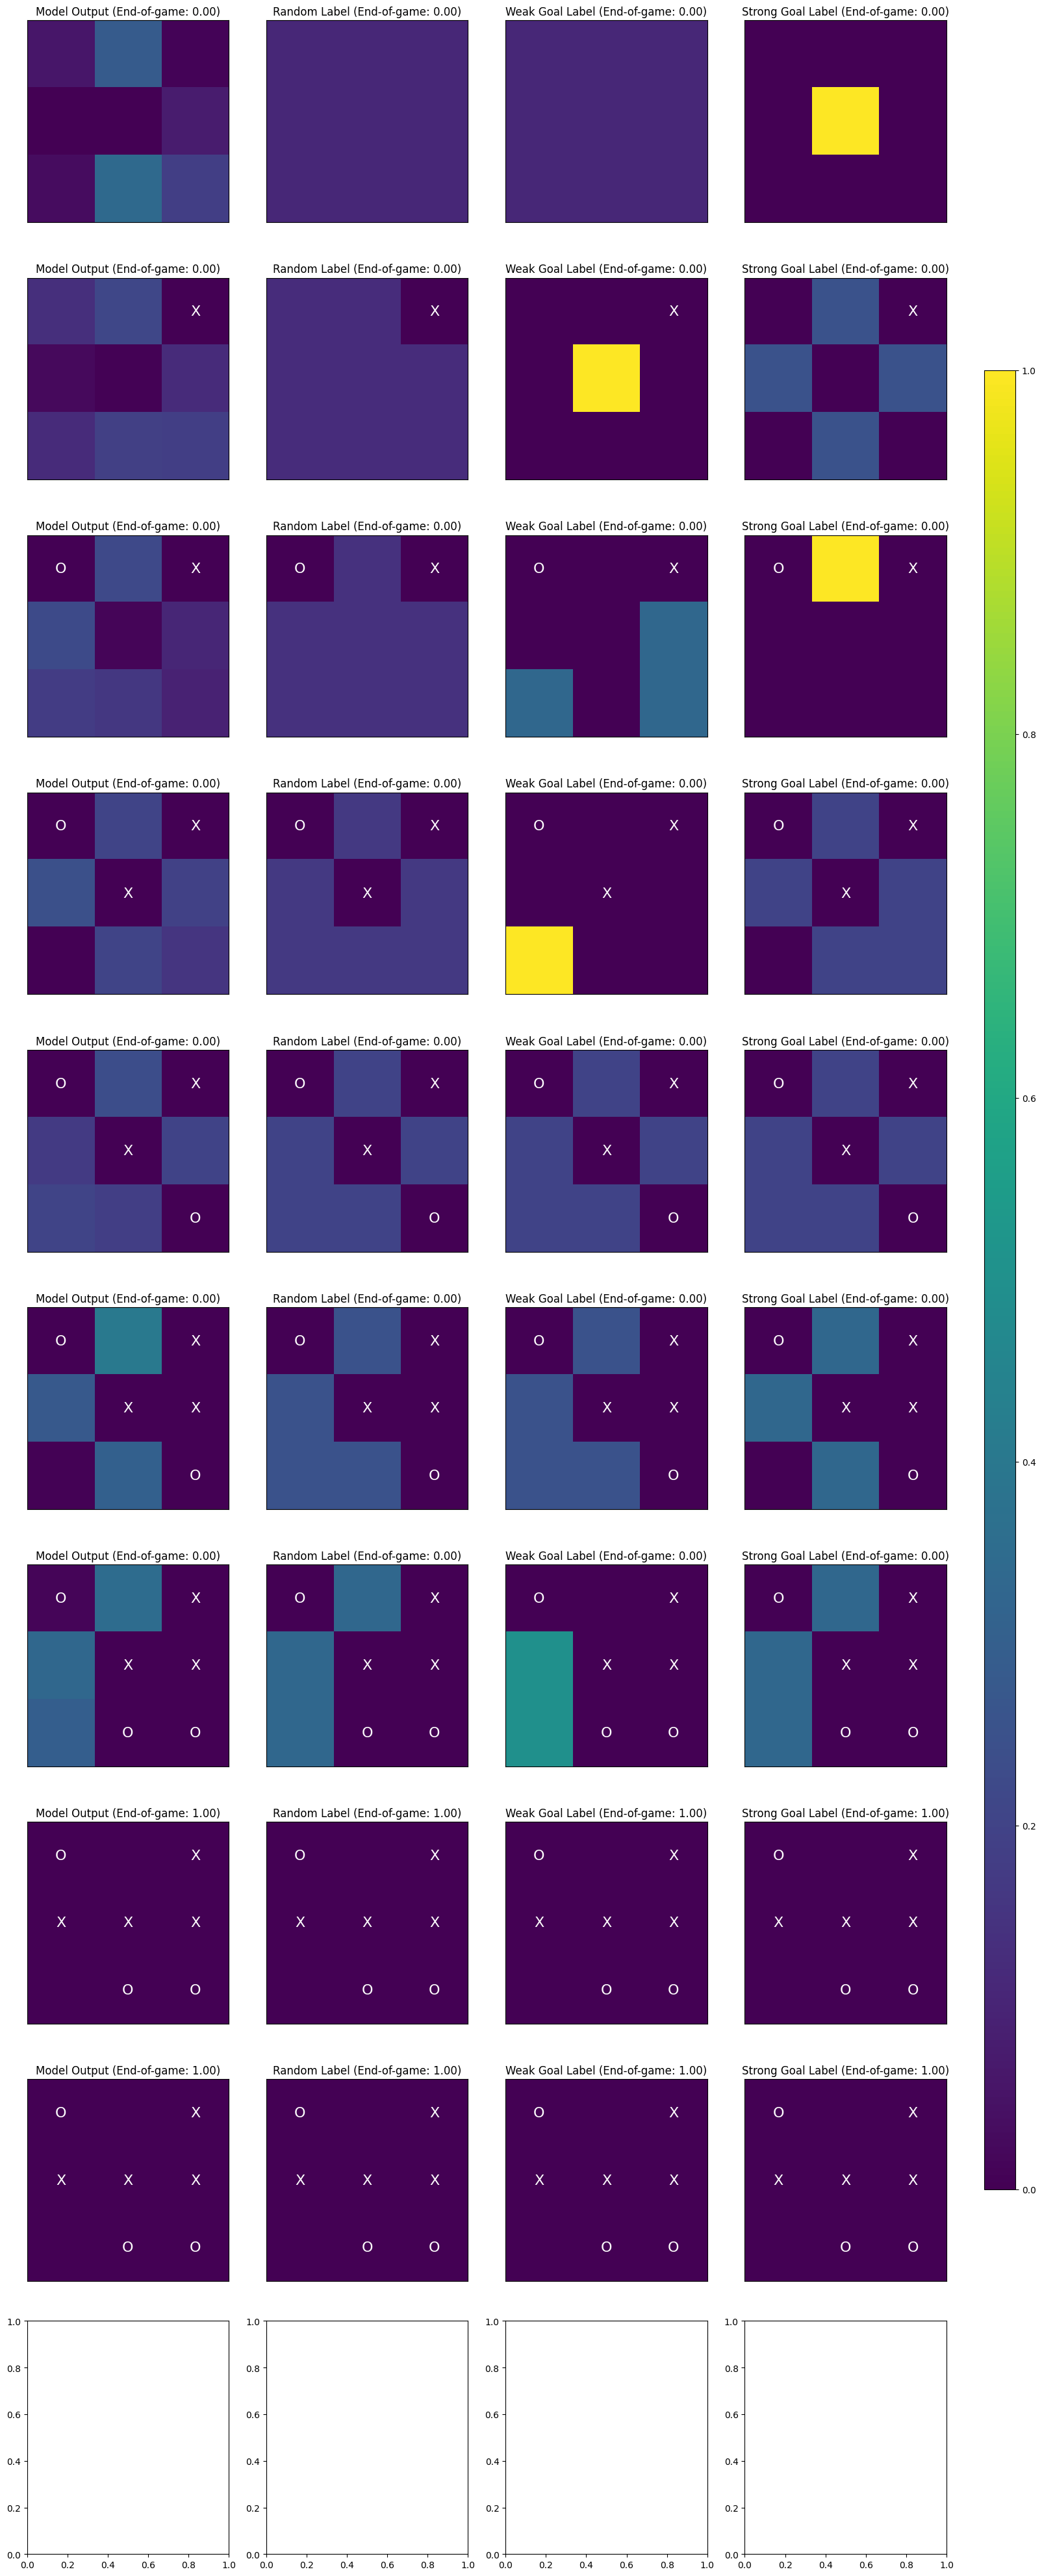

In [ ]:
visualize_game(tictactoe_test_data, game_id=0, model=model)

# Sample games

In [ ]:
samples = sample_games(model, 1, 100)

In [ ]:
evals.eval_model(samples)

NameError: name 'evals' is not defined

In [ ]:
sample = samples[1]
print(sample)

In [ ]:
from alphatoe.game import Board, State

def check(game: list[int]) -> bool:
    board = Board()
    for move in game[1:-1]:
        print(move)
        if board.game_state == State.ONGOING:
            try:
                board.make_move(move)
            except:
                return True
        elif move == 9:
            pass
        else:
            return True
    return False

check(sample)

In [ ]:
game.play_game(sample)
print("\nPLAY:")
board = game.Board()
for move in sample:
  if move not in [9, 10]:
    board.make_move(move)
    board.draw_board()
    print(".")

In [ ]:
print(evals.model_vs_minimax(model, True), "\n")
print(evals._check_minimax_win_rate(model, 100))

In [ ]:
evals.get_error_rate(samples)